In [41]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_cap_model_Numba import newtonRaphsonCap, wrappedNewtonCap

In [42]:
# specifing data location and folder for output

data_name = '9 150_1_cv_current_reduced_0'
file_name = data_name + '.txt'
folder = os.path.join('Data', 'processed')
folder = os.path.join(folder, '220415')
folder = os.path.join(folder, 'ph9 2m nacl 25oC')
folder = os.path.join(folder, 'ac')
# folder = os.path.join(folder, '9_2b')
folder = os.path.join(folder, '9 150_1')
data_folder = os.path.join(folder, 'experimental')
data_file = os.path.join(data_folder, file_name)

# creating file for output
output_file_name = 'fitting_for_capacitance_data.txt'
folder = os.path.join(folder, 'current_fitting')
f= open(os.path.join( folder, output_file_name),"w")

# opening data
experimental_data = pd.read_csv(data_file, sep='\t')

exp_times = np.asarray(experimental_data.time)
exp_current = np.asarray(experimental_data.current)

In [43]:
# delacring know model paramters

inital_current = exp_current[0]
freq = 8.977950e+00
startPotential= -300.0E-3
revPotential = -900.0E-3
rateOfPotentialChange = -22.35174e-3


deltaepislon = 150.0E-3
electrode_area = 0.03
electode_coverage = 6.5e-12

measured_removed_for_Int_periods = 0

In [44]:
numberOfMeasurements = exp_times.shape
# sepcifing model to get I0 for non deminsionalisation
trial = newtonRaphsonCap(timeStepSize = exp_times[1], numberOfMeasurements = numberOfMeasurements[0], startPotential= startPotential,
                         revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, inital_current=inital_current,
                         freq=freq, deltaepislon=deltaepislon, electrode_area=electrode_area, electode_coverage=electode_coverage)

# non-diming experimental data
exp_current_dimless = exp_current/trial.I0

# model for optimsation
cap_regions = 0.2# perctange of data run
model = wrappedNewtonCap(times = exp_times, removed_measures_to_account_for = measured_removed_for_Int_periods, 
                         startPotential= startPotential, revPotential = revPotential,
                         rateOfPotentialChange = rateOfPotentialChange, inital_current=inital_current, freq=freq,
                         deltaepislon=deltaepislon, electrode_area=electrode_area, electode_coverage=electode_coverage,
                         beingPureCapitanceto = cap_regions, endPureCapatianceFor = cap_regions)

real_parameters = model.suggested_capacitance_params()
parameter_order = ['gamma0', 'gamma1', 'gamma2', 'gamma3', 'gamma4', 'gamma5', 'gamma6', 'gamma7', 'omega', 'mew', 'row']
real_parameters = np.asarray(real_parameters)
f.write("experimental data: " + data_file + "\r\n")
print('experimental data: ',data_file)

self.endPureCapatianceFor:  9986
self.beingPureCapitanceto:  9986
experimental data:  Data/processed/220415/ph9 2m nacl 25oC/ac/9 150_1/experimental/9 150_1_cv_current_reduced_0.txt


In [45]:
class RegionalSumOfSquaresError(pints.ProblemErrorMeasure):
    r"""
     Calculates a sum of squares error:

    .. math::
        f = \sum _i^n (y_i - x_i) ^ 2,

    where :math:`y` is the data, :math:`x` the model output and :math:`n` is
    the total number of data points.

    Extends :class:`ErrorMeasure`.

    Parameters
    ----------
    problem
        A :class:`pints.SingleOutputProblem`
    """
    def __init__(self, problem, beingPureCapitanceto, midCapLow, midCaphigh, endCap):
        super(RegionalSumOfSquaresError, self).__init__(problem)
        
        self.beingPureCapitanceto = beingPureCapitanceto
        self.midCapLow = midCapLow
        self.midCaphigh = midCaphigh
        self.endCap = endCap

        self.Cap_region_values = self.reshape_to_cap_regions(self._values)


    def __call__(self, x):
        # print('calling model')
        simulation = self._problem.evaluate(x)
        # print('completed model evaulation')
        # print('caculating score')
        Cap_region_sim = self.reshape_to_cap_regions(simulation)

        difference = Cap_region_sim - self.Cap_region_values

        squared = np.square(difference)

        sumed = np.sum(squared)
        
        return sumed

    def reshape_to_cap_regions(self, array):

        raw = np.asarray(array)
        a = raw[:self.beingPureCapitanceto]
        b = raw[self.midCapLow:self.midCaphigh]
        c = raw[self.endCap:]
        reshaped = np.hstack((a,b,c))
        return reshaped


In [46]:
problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

score = RegionalSumOfSquaresError(problem = problem,
                                  beingPureCapitanceto = model.beingPureCapitanceto,
                                  midCapLow = model.midCapLow,
                                  midCaphigh = model.midCaphigh,
                                  endCap = model.endCap)

omega0 = model.get_omega_0()
# orginal range in new format
# lower_bounds = np.asarray([0.0, -10, -1, -1, 1.1*omega0, -0.314])
# upper_bounds = np.asarray([10, 10, 1, 1, 0.9*omega0, 0.314])
#range I should be using if adjusting CD without others
# lower_bounds = np.asarray([0.0, -0.0010, -0.00010, -0.00010, 1.1*omega0, -0.314, 0.7*27.160770551])
# upper_bounds = np.asarray([0.0010, 0.0010, 0.00010, 0.00010, 0.9*omega0, 0.314, 1.3*27.160770551])
# ranges that didn't jam but found max at edge
# lower_bounds = np.asarray([0.0, -0.00010, -0.00010, -0.00010, 0.0, -0.00010, -0.00010, -0.00010, 0.99*omega0, -0.1*math.pi, 0.5*27.160770551])
# upper_bounds = np.asarray([0.0010, 0.00010, 0.00010, 0.00010, 0.0010, 0.00010, 0.00010, 0.00010, 1.01*omega0, 0.1*math.pi, 4.0*27.160770551])

lower_bounds = np.asarray([0.0, -0.0010, -0.0010, -0.0010, 0.0, -0.0010, -0.0010, -0.0010, 0.99*omega0, -0.15*math.pi, 0.01*27.160770551])
upper_bounds = np.asarray([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 1.01*omega0, 0.15*math.pi, 5.0*27.160770551])


# lower_bounds = np.asarray([0.0, -0.1, -0.01, -0.01, 0.0, -0.1, -0.01, -0.01, 0.99*omega0, -0.15*math.pi, 0.1*27.160770551])
# upper_bounds = np.asarray([0.1, 0.1, 0.01, 0.01, 0.1, 0.1, 0.01, 0.01, 1.01*omega0, 0.15*math.pi, 5.0*27.160770551])



# lower_bounds = np.asarray([0.0, -0.00050, -0.00050, -0.00050, 1.01*omega0, -0.1*math.pi, 0.5*27.160770551])
# upper_bounds = np.asarray([0.0010, 0.00050, 0.00050, 0.00050, 0.99*omega0, 0.1*math.pi, 4.0*27.160770551])
boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)

# print("Score at papers solution:", "{:.12e}".format(score(real_parameters)))
# found_params = [1.13465158675681913e-04, 1.71228672908262905e-06,
#                 -2.02632468231267758e-05, -6.41028656277626023e-05,
#                 1.13465158675681913e-04, 1.71228672908262905e-06,
#                 -2.02632468231267758e-05, -6.41028656277626023e-05,
#                 -6.47083954113886932e+01, -8.82407598543352156e-02,
# print("Score at found solution:", "{:.12e}".format(score(found_params)))
# cap = 0.15 (6824)
# Score at papers solution: 1839478952.0111494
# Score at found solution: 40310696.33102664

best_solution = [1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
-6.47034179321291987e+01/trial.T0, -9.02693680260502618e-02,  8.49461271867468355e+01]

print("Score at old best solution:", "{:.12e}".format(score(best_solution)))

# New_best_solution = [1.86462230414513049e-04,  1.40232076599220573e-04,
#                      3.63609223469458197e-04,  1.85360935490469676e-04,
#                      1.89273892796364726e-04,  1.71687850083388893e-04,
#                      4.33041822974022808e-04,  2.35505934471443804e-04,
#                      -6.47033571693596627e+01, -1.03037377017087317e-01,
#                      3.23065319593442695e+01]
# print("Score at new best solution:", "{:.12e}".format(score(New_best_solution)))
# Score at old best solution: 5.012434584386e+07

Score at old best solution: 6.590916748721e+07


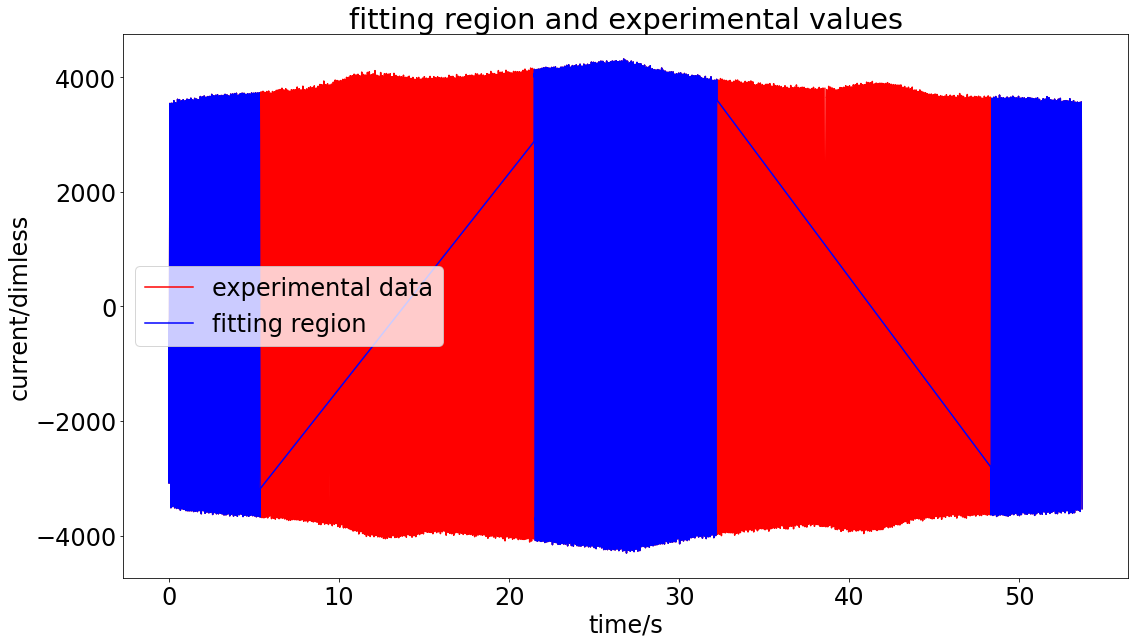

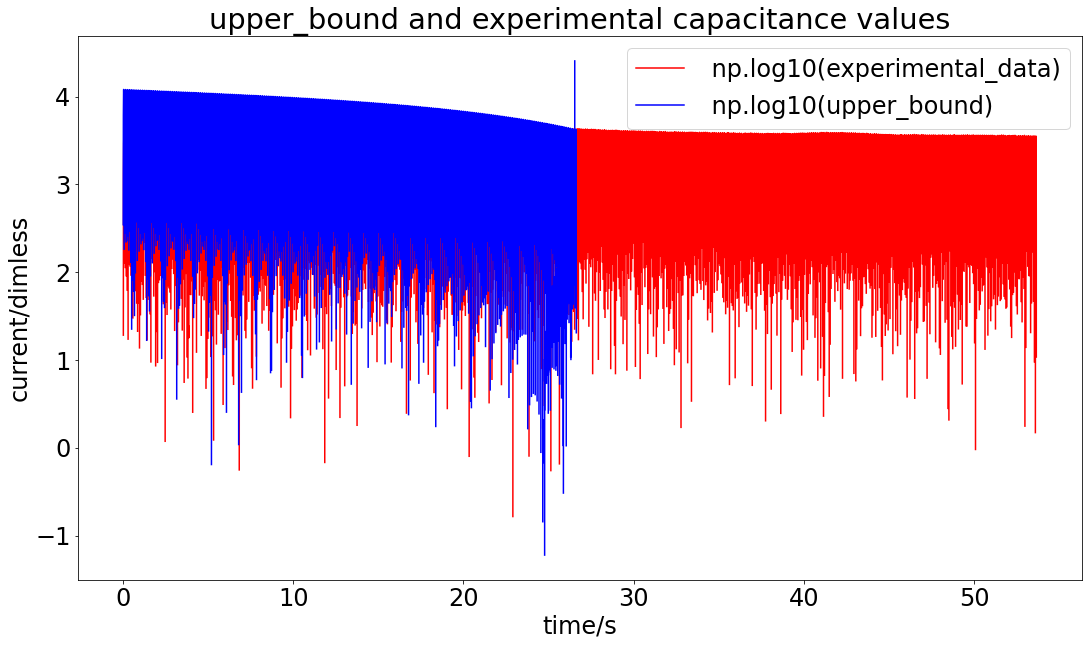

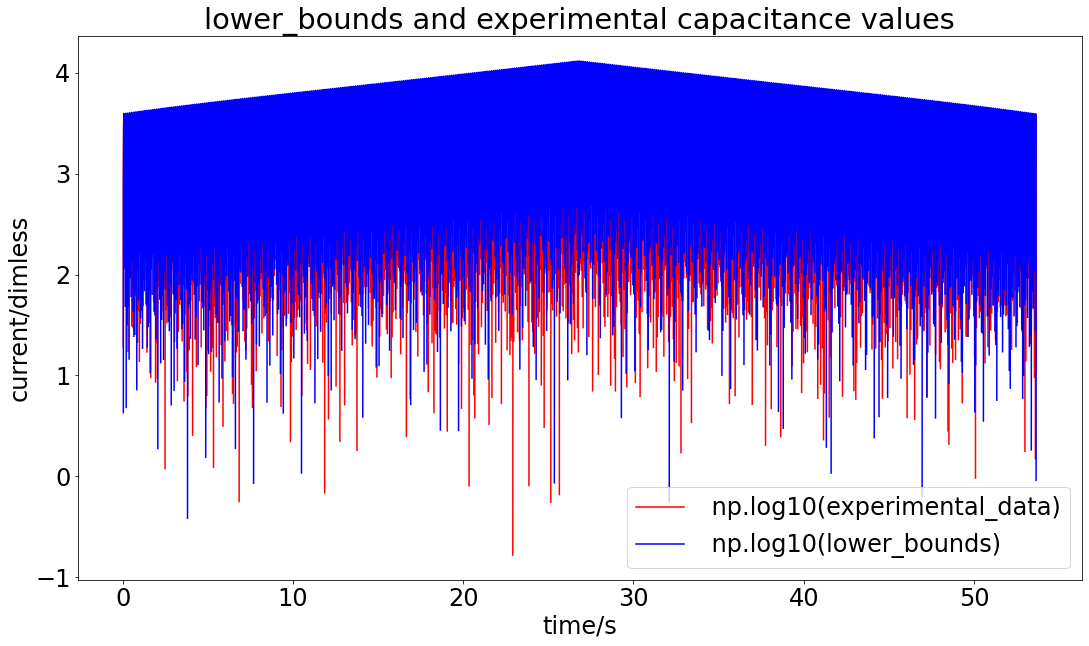

In [47]:
reduced_data = model.reshape_to_cap_regions(exp_current_dimless)
xaxis = model.reshape_to_cap_regions(exp_times) #model.potentialRange
xaxislabel = "time/s" # "potential/V"


plt.figure(figsize=(18,10))
plt.title("fitting region and experimental values")
plt.ylabel("current/dimless")
plt.xlabel(xaxislabel)
plt.plot(exp_times, exp_current_dimless,'r', label='experimental data')
plt.plot(xaxis ,reduced_data,'b', label='fitting region')
plt.legend(loc='best')
plt.show()

#checking extreme of range

data = model.simulate(upper_bounds,exp_times)
plt.figure(figsize=(18,10))
plt.title("upper_bound and experimental capacitance values")
plt.ylabel("current/dimless")
plt.xlabel(xaxislabel)
plt.plot(exp_times,  np.log10(exp_current_dimless),'r', label=' np.log10(experimental_data)')
plt.plot(exp_times,  np.log10(data),'b', label=' np.log10(upper_bound)')
plt.legend(loc='best')
plt.show()

data = model.simulate(lower_bounds,exp_times)
plt.figure(figsize=(18,10))
plt.title("lower_bounds and experimental capacitance values")
plt.ylabel("current/dimless")
plt.xlabel(xaxislabel)
plt.plot(exp_times, np.log10(exp_current_dimless),'r', label=' np.log10(experimental_data)')
plt.plot(exp_times , np.log10(data),'b', label=' np.log10(lower_bounds)')
plt.legend(loc='best')
plt.show()

# data = model.simulate(best_solution,exp_times)
# plt.figure(figsize=(18,10))
# plt.title("old best solution and experimental capacitance values")
# plt.ylabel("current/dimless")
# plt.xlabel(xaxislabel)
# plt.plot(exp_times, exp_current_dimless,'r', label='experimental data')
# plt.plot(exp_times , data,'b', label='old best solution')
# plt.legend(loc='best')
# plt.savefig(os.path.join( folder, 'old best solution.pdf'))
# plt.show()

In [48]:
total_runs = 3
dims = real_parameters.shape
print('dims: ', dims)
print('dims[0]: ', dims[0])
params_matrix = np.zeros((total_runs, dims[0]))
for run in range(total_runs):
        
    if run > 0:
        f = open(os.path.join( folder, output_file_name),"a")

    f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
    print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
    accuracy = (2 + run)
    # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
    # print('Threshold for stopping: ', pow(10,-accuracy))

    ranges = upper_bounds - lower_bounds 

    starting_points = np.copy(lower_bounds)
    for i in range(len(ranges)):
        # starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
        starting_points[i] += ranges[i] * np.random.uniform(low = 0.2, high = 0.8)
    
    print('lower_bounds: ', lower_bounds)
    print('upper_bounds: ', upper_bounds)

    if run == 0 or run ==1:
        starting_points =[1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
-6.47034179321291987e+01/trial.T0, -9.02693680260502618e-02,  8.49461271867468355e+01]
    print('random starting points: ', starting_points)

    f.write("lower_bounds: ")
    for i in lower_bounds:
        f.write("%e, " % i)
    f.write("\r\nupper_bounds: ")
    for i in upper_bounds:
        f.write("%e, " % i)
    f.write("\r\nRandom starting_points: ")
    for i in starting_points:
        f.write("%e, " % i)
    f.write("\r\n")

    # transformation
    transform = pints.RectangularBoundariesTransformation(boundaries)

    # optimising boundaries=boundaries,
    opt = pints.OptimisationController(
        score,
        x0=starting_points,
        method=pints.CMAES,
        transform = transform)

        
    #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
    #opt.set_max_unchanged_iterations(iterations=100)
    opt.set_parallel(parallel=True)
    #opt.set_max_iterations(iterations=10)
    opt.set_log_interval(iters=10, warm_up=3)
    #opt.set_threshold(threshold=-??????)
    
    found_parameters, found_value =  opt.run()
        #CMAES, PSO, SNES, XNES
    # output results

    print('random starting points: ', starting_points)

    f.write("Found solution: ")
    for k, x in enumerate(found_parameters):
        f.write(pints.strfloat(x) +", ")

    print('         Found solution:' )
    name = 0
    for k, x in enumerate(found_parameters):
        print( pints.strfloat(x) + '  :' + parameter_order[name])
        name = name + 1

    print('lower_bounds: ', lower_bounds)
    print('upper_bounds: ', upper_bounds)

    f.write("\r\n\r\nFound solution:\r\n")
    name = 0
    for k, x in enumerate(found_parameters):
        f.write(pints.strfloat(x) + '  :' + parameter_order[name]+ '\r\n')
        name = name + 1

    params_matrix[run, :] = found_parameters

    # plotting current for found parameters over the experimentally data

    xaxis = exp_times #model.potentialRange
    xaxislabel = "time/s" # "potential/V"
    solution = model.simulate(found_parameters, exp_times)


    plt.figure(figsize=(18,10))
    plt.title("optimised and experimental capacitance values")
    plt.ylabel("current/dimless")
    plt.xlabel(xaxislabel)
    plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
    plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment against optimised capacitance: run '+str(run)+'.pdf'))
    #plt.show()
    plt.close()

    # plt.figure(figsize=(18,10))
    # plt.title("optimised and experimental capacitance values")
    # plt.ylabel("current/dimless")
    # plt.xlabel(xaxislabel)
    # plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
    # plt.plot(xaxis,exp_current_dimless,'r', label='experiment_'+str(real_parameters[0])+'_'+str(real_parameters[1]))
    # plt.legend(loc='best')
    # plt.savefig(os.path.join( folder, 'optimised against experimental capacitance: run '+str(run)+'.png'))
    # #plt.show()
    # plt.close()

    print("Score at found solution:", score(found_parameters))
    f.write("Score at found solution: %.16e\r\n" % score(found_parameters))

    run += run
f.close()

# 144 aiming for 3.9028647914590866e+10

dims:  (11,)
dims[0]:  11


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.00000000e+00 -1.00000000e-03 -1.00000000e-03 -1.00000000e-03
  0.00000000e+00 -1.00000000e-03 -1.00000000e-03 -1.00000000e-03
  5.58460223e+01 -4.71238898e-01  2.71607706e-01]
upper_bounds:  [1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 5.69742248e+01 4.71238898e-01 1.35803853e+02]
random starting points:  [0.000166897412567862, -0.0003319799151255766, -0.0005191430409762811, -0.0003204778363149887, 0.00021302944458313208, -9.509665687249154e-05, -0.0001669493442716134, -0.00014981354286658854, 56.293081856252506, -0.09026936802605026, 84.94612718674684]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 11
Iter. Eval.  Best      Time m:s
0     11      6.27e+09   0:00.6
1    

KeyboardInterrupt: 